# Load

In [1]:
import io
import logging
import math
import sys
import pandas as pd
from typing import Tuple, get_args
from py_ballisticcalc import Ammo, Atmo, Weapon, Shot, Calculator, HitResult
from py_ballisticcalc import ZeroFindingError, RangeError, TrajFlag, BaseEngineConfigDict, SciPyEngineConfigDict
from py_ballisticcalc import TableG7, logger, loadMetricUnits
from py_ballisticcalc.drag_model import DragModel
from py_ballisticcalc.helpers import must_fire, find_index_for_time_point
from py_ballisticcalc.unit import *
from py_ballisticcalc.interface import _EngineLoader
logger.setLevel(logging.WARNING)
print("\nAvailable engines: " + str(sorted([e.name for e in _EngineLoader.iter_engines()])))
loadMetricUnits()
PreferredUnits.drop = Distance.Meter
PreferredUnits.distance = Distance.Meter


Available engines: ['cythonized_euler_engine', 'cythonized_rk4_engine', 'euler_engine', 'rk4_engine', 'scipy_engine', 'verlet_engine']


## Reference Calculator

This _reference calculator_ will determine the "correct" trajectory against which the error of all others will be measured.


In [2]:
ref_config = SciPyEngineConfigDict(
    relative_tolerance=1e-12,
    absolute_tolerance=1e-12,
    integration_method="LSODA",
)
ref_calc = Calculator(ref_config, engine='scipy_engine')

# Scenarios

## 2km flat-fire trajectory

A typical 7.62mm bullet launched at an elevation (60mils, about 3.375 degrees) sufficient to reach approximately 2km.  We use the reference calculator to compute the trajectory.

,time,distance,velocity,mach,height,angle,density_factor,drag,energy,flag
1,0.001 s,0.7 m,800 m/s,2.35 mach,-0.0 m,3.3744 °,2.173e-05,0.691,3196 J,ZERO_UP
10,1.564 s,814.0 m,340 m/s,1.00 mach,38.8 m,1.5851 °,-3.693e-03,0.401,579 J,MACH
13,2.440 s,1086.3 m,292 m/s,0.86 mach,42.7 m,-0.0000 °,-4.071e-03,0.120,426 J,APEX
22,5.534 s,1861.7 m,219 m/s,0.64 mach,0.0 m,-6.9538 °,2.173e-05,0.081,240 J,ZERO_DOWN


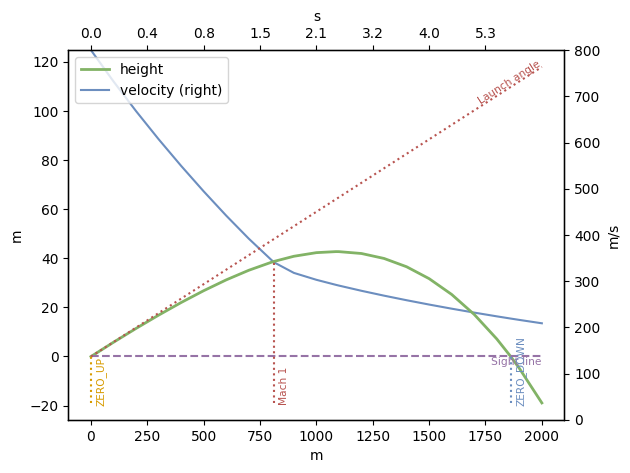

In [3]:
dm = DragModel(0.22, TableG7, Weight.Gram(10), Distance.Centimeter(7.62), Distance.Centimeter(3.0))
ammo = Ammo(dm, Velocity.MPS(800))
weapon = Weapon(sight_height=Distance.Centimeter(4), twist=Distance.Centimeter(30), zero_elevation=Angular.Mil(60.0))
baseline_shot = Shot(weapon=weapon, ammo=ammo, atmo=Atmo.icao())
range = Distance.Meter(2000)
range_step = Distance.Meter(100)
reference_trajectory = ref_calc.fire(shot=baseline_shot, trajectory_range=range, trajectory_step=range_step, extra_data=True)
reference_trajectory.plot()
ref = reference_trajectory.dataframe(True).drop(columns=['slant_height', 'drop_adj', 'windage', 'windage_adj', 'slant_distance', 'ogw'])
ref[ref.flag != "RANGE"]

### Define error

We will take the ZERO_DOWN (return-to-zero) row as our reference point for assessing the error in other engines.

In [4]:
reference_row = reference_trajectory.flag(TrajFlag.ZERO_DOWN)
reference_distance = reference_row.distance
reference_distance_meter = reference_distance >> Distance.Meter
def check_error(hit: HitResult, output: bool = False) -> float:
    """Error is vertical distance from zero at the reference distance."""
    chkpt = hit.get_at_distance(reference_distance)
    if chkpt is not None:
        chk_x = chkpt.distance >> Distance.Meter
        chk_h = chkpt.height >> Distance.Meter
        chk_err = math.sqrt((chk_x-reference_distance_meter)**2 + chk_h**2)
        if output:
            print(f'At {chkpt.time}s: ({chk_x}, {chk_h})m ==> Error = {chk_err:.8f}m')
        return chk_err
    return float('inf')

summary = []

## SciPy

In [5]:
def scipy_chk(timeit: bool = False, **kwargs):
    config = SciPyEngineConfigDict(
        **kwargs,
    )
    calc = Calculator(config, engine='scipy_engine')
    hit, e = must_fire(calc, shot=baseline_shot, trajectory_range=range, trajectory_step=reference_distance)
    err = check_error(hit)
    evals = calc.integration_step_count
    if timeit:
        speed = %timeit -o must_fire(calc, shot=baseline_shot, trajectory_range=range, trajectory_step=reference_distance)
        return err, evals, speed.average
    return err, evals
logger.setLevel(logging.WARNING)
# Run with default tolerance:
err, count, speed = scipy_chk(timeit=True, integration_method="LSODA")
print(f'Error={err:.8f}m.  Integration steps: {count}.  Speed: {speed:.5f}s')

74.5 ms ± 17.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Error=0.00016476m.  Integration steps: 1776.  Speed: 0.07454s


### Integration Methods

Here's a quick look at each of the integration methods listed in the SciPyIntegrationEngine, using its default error tolerance settings.

In [6]:
from py_ballisticcalc.engines.scipy_engine import INTEGRATION_METHOD
method_summary = []
for method in get_args(INTEGRATION_METHOD):
    err, count, speed = scipy_chk(timeit=True, integration_method=method)
    method_summary.append(('SciPy', method, err, count, speed))
pd.DataFrame(method_summary, columns=['Engine', 'Setting', 'Error (m)', 'Integration Steps', 'Speed (s)']).set_index('Setting').sort_values(by='Error (m)', ascending=True)

72.7 ms ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
33.3 ms ± 5.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
126 ms ± 7.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
287 ms ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
195 ms ± 3.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
60.3 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


,Engine,Error (m),Integration Steps,Speed (s)
Setting,,,,
Radau,SciPy,0.000003,4591,0.287109
BDF,SciPy,0.000036,1965,0.194731
RK23,SciPy,0.000076,1583,0.072659
LSODA,SciPy,0.000165,1776,0.060251
DOP853,SciPy,0.000852,5402,0.126346
RK45,SciPy,0.001351,1118,0.033290


### Tolerance

SciPy allows us to specify both "absolute" and "relative" error tolerance.  The meaning of the two terms and their interaction isn't always intuitive, so let's see what happens as we vary each while holding out the other term.  We'll do this for both the LSODA and RK45 methods.

#### LSODA

In [7]:
tol_tests = []
method = 'LSODA'
# Run with rtol as limiting factor
rtol = 1e-1
atol = 1e-13
while rtol > 1e-10:
    rtol /= 10.0
    err, count = scipy_chk(integration_method=method, relative_tolerance=rtol, absolute_tolerance=atol)
    tol_tests.append((method, atol, rtol, err, count))
# Run with atol as limiting factor
atol = 1e-1
rtol = 1e-13
while atol > 1e-10:
    atol /= 10.0
    err, count = scipy_chk(integration_method=method, relative_tolerance=rtol, absolute_tolerance=atol)
    tol_tests.append((method, atol, rtol, err, count))
display(
    pd.DataFrame(tol_tests, columns=['Method', 'Absolute Tolerance', 'Relative Tolerance', 'Error (m)', 'Integration Steps'])
      .sort_values(by='Error (m)', ascending=False)
      .style.format({'Absolute Tolerance': '{:.1e}', 'Relative Tolerance': '{:.1e}', 'Error (m)': '{:.11f}'}))

,Method,Absolute Tolerance,Relative Tolerance,Error (m),Integration Steps
0,LSODA,1.0e-13,1.0e-02,0.78836705253,121
2,LSODA,1.0e-13,1.0e-04,0.02085849732,162
10,LSODA,1.0e-02,1.0e-13,0.00539150910,171
4,LSODA,1.0e-13,1.0e-06,0.00227701489,496
11,LSODA,1.0e-03,1.0e-13,0.00207619842,458
3,LSODA,1.0e-13,1.0e-05,0.00130312391,263
1,LSODA,1.0e-13,1.0e-03,0.00087850598,155
5,LSODA,1.0e-13,1.0e-07,0.00079173517,1041
12,LSODA,1.0e-04,1.0e-13,0.00019150664,1013
6,LSODA,1.0e-13,1.0e-08,0.00009840609,1787


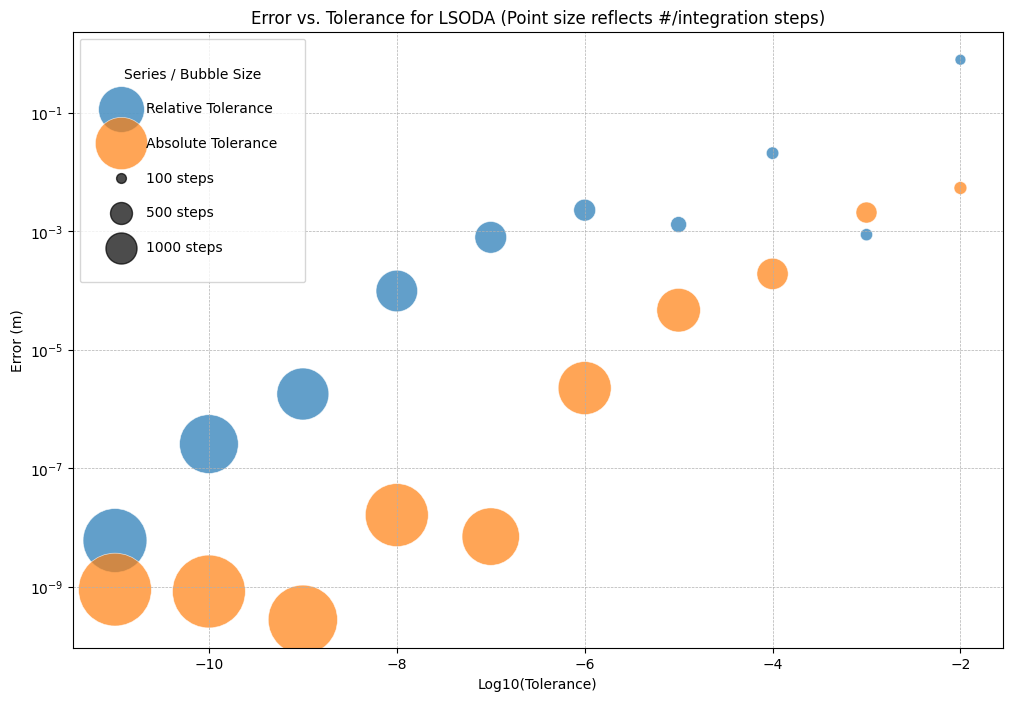

In [8]:
import matplotlib.pyplot as plt
import numpy as np
df_tol = pd.DataFrame(tol_tests, columns=['Method', 'Absolute Tolerance', 'Relative Tolerance', 'Error (m)', 'Integration Steps'])
# Separate the two series of data
atol_fixed = df_tol[df_tol['Absolute Tolerance'] == 1e-13].copy()
rtol_fixed = df_tol[df_tol['Relative Tolerance'] == 1e-13].copy()

fig, ax = plt.subplots(figsize=(12, 8))
# Plot the series where Absolute Tolerance is fixed
ax.scatter(
    np.log10(atol_fixed['Relative Tolerance']),
    atol_fixed['Error (m)'],
    s=atol_fixed['Integration Steps'] * 0.5,  # Scale size for better visibility
    label='Relative Tolerance',
    alpha=0.7,
    edgecolors='w',
    linewidth=0.5
)
# Plot the series where Relative Tolerance is fixed
ax.scatter(
    np.log10(rtol_fixed['Absolute Tolerance']),
    rtol_fixed['Error (m)'],
    s=rtol_fixed['Integration Steps'] * 0.5,  # Scale size for better visibility
    label='Absolute Tolerance',
    alpha=0.7,
    edgecolors='w',
    linewidth=0.5
)
ax.set_xlabel('Log10(Tolerance)')
ax.set_ylabel('Error (m)')
ax.set_title('Error vs. Tolerance for LSODA (Point size reflects #/integration steps)')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_yscale('log') # Use a log scale for error to see the full range
# Add a legend for bubble sizes
for steps in [100, 500, 1000]:
    ax.scatter([], [], s=steps * 0.5, c='k', alpha=0.7, label=f'{steps} steps')
ax.legend(title='Series / Bubble Size', scatterpoints=1, labelspacing=1.5, borderpad=2)
plt.show()

#### RK45

In [9]:
method = 'RK45'
# Run with rtol as limiting factor
rtol = 1e-1
atol = 1e-13
while rtol > 1e-10:
    rtol /= 10.0
    try:
        err, count = scipy_chk(integration_method=method, relative_tolerance=rtol, absolute_tolerance=atol)
        tol_tests.append((method, atol, rtol, err, count))
    except ArithmeticError as e:
        print(f"Failed to reach distance with {rtol=}")
        continue
# Run with atol as limiting factor
atol = 1e-1
rtol = 1e-13
while atol > 1e-10:
    atol /= 10.0
    try:
        err, count = scipy_chk(integration_method=method, relative_tolerance=rtol, absolute_tolerance=atol)
        tol_tests.append((method, atol, rtol, err, count))
    except ArithmeticError as e:
        print(f"Failed to reach distance with {atol=}")
        continue
df_tol = pd.DataFrame(tol_tests, columns=['Method', 'Absolute Tolerance', 'Relative Tolerance', 'Error (m)', 'Integration Steps']).sort_values(by='Error (m)', ascending=False)
display(df_tol[df_tol['Method'] == 'RK45'].sort_values(by='Error (m)', ascending=False)
      .style.format({'Absolute Tolerance': '{:.1e}', 'Relative Tolerance': '{:.1e}', 'Error (m)': '{:.11f}'}))

,Method,Absolute Tolerance,Relative Tolerance,Error (m),Integration Steps
20,RK45,1.0e-13,1.0e-02,4.80902599635,110
21,RK45,1.0e-13,1.0e-03,1.42335689541,116
22,RK45,1.0e-13,1.0e-04,0.13834681911,134
23,RK45,1.0e-13,1.0e-05,0.05931755799,170
31,RK45,1.0e-03,1.0e-13,0.02401295393,176
30,RK45,1.0e-02,1.0e-13,0.02320768712,110
24,RK45,1.0e-13,1.0e-06,0.01041117103,218
25,RK45,1.0e-13,1.0e-07,0.00970797018,428
32,RK45,1.0e-04,1.0e-13,0.00335060298,512
26,RK45,1.0e-13,1.0e-08,0.00077076278,1364


#### Chart

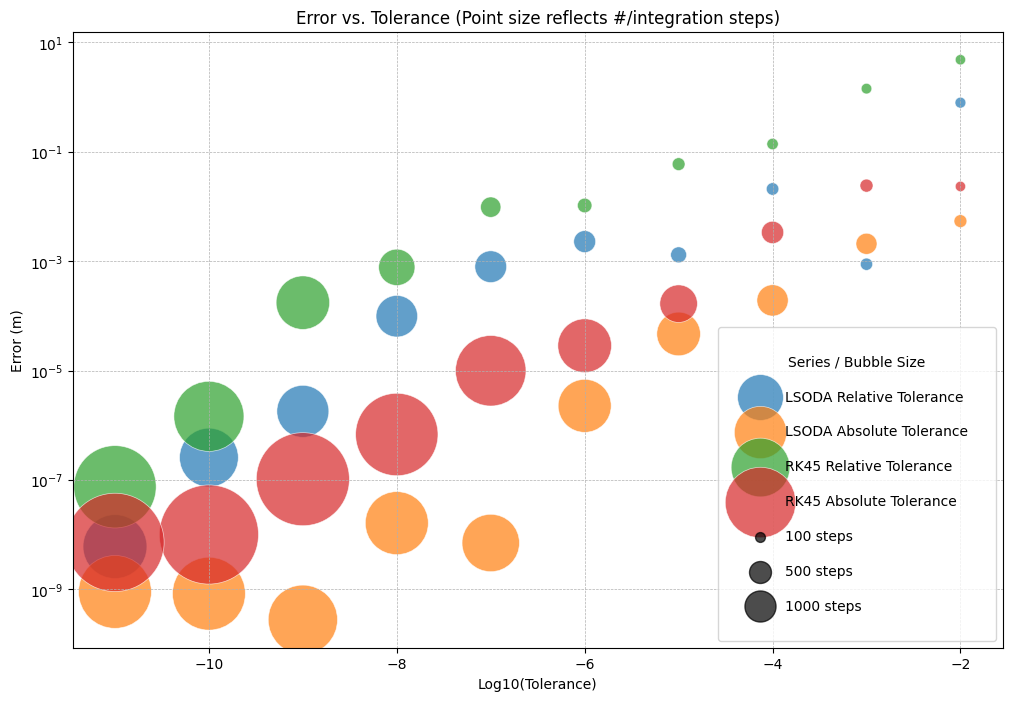

In [10]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(12, 8))
for method in ['LSODA', 'RK45']:
    atol_fixed = df_tol[(df_tol.Method == method) & (df_tol['Absolute Tolerance'] == 1e-13)].copy()
    rtol_fixed = df_tol[(df_tol.Method == method) & (df_tol['Relative Tolerance'] == 1e-13)].copy()
    # Plot the series where Absolute Tolerance is fixed
    ax.scatter(
        np.log10(atol_fixed['Relative Tolerance']),
        atol_fixed['Error (m)'],
        s=atol_fixed['Integration Steps'] * 0.5,  # Scale size for better visibility
        label=method + ' Relative Tolerance',
        alpha=0.7,
        edgecolors='w',
        linewidth=0.5
    )
    # Plot the series where Relative Tolerance is fixed
    ax.scatter(
        np.log10(rtol_fixed['Absolute Tolerance']),
        rtol_fixed['Error (m)'],
        s=rtol_fixed['Integration Steps'] * 0.5,  # Scale size for better visibility
        label=method + ' Absolute Tolerance',
        alpha=0.7,
        edgecolors='w',
        linewidth=0.5
    )
ax.set_xlabel('Log10(Tolerance)')
ax.set_ylabel('Error (m)')
ax.set_title('Error vs. Tolerance (Point size reflects #/integration steps)')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_yscale('log') # Use a log scale for error to see the full range
# Add a legend for bubble sizes
for steps in [100, 500, 1000]:
    ax.scatter([], [], s=steps * 0.5, c='k', alpha=0.7, label=f'{steps} steps')
ax.legend(title='Series / Bubble Size', scatterpoints=1, labelspacing=1.5, borderpad=2)
plt.show()

### Chosen Methods

For purposes of charting against the non-SciPy methods, we'll vary these two SciPy methods over a range of tolerance settings that give monotonically increasing error with speed.

In [11]:
method = 'RK45'
atol = 1e-10
while atol < 0.1:
    err, count, speed = scipy_chk(timeit=True, integration_method=method, absolute_tolerance=atol, relative_tolerance=1e-12)
    summary.append(('SciPy '+method, atol, err, count, speed))
    atol *= 10.0
df = pd.DataFrame(summary, columns=['Engine', 'atol', 'Error (m)', 'Integration Steps', 'Speed (s)'])
display(df[df.Engine == 'SciPy '+method].style.format({'atol': '{:.1e}', 'Error (m)': '{:.10f}'}))

339 ms ± 53.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
294 ms ± 40.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
251 ms ± 79.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
143 ms ± 9.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
79.5 ms ± 956 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
38.4 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
14.5 ms ± 271 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.76 ms ± 124 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.13 ms ± 263 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


,Engine,atol,Error (m),Integration Steps,Speed (s)
0,SciPy RK45,1.0e-10,0.0000000151,8702,0.338535
1,SciPy RK45,1.0e-09,0.0000001255,7520,0.294350
2,SciPy RK45,1.0e-08,0.0000002763,6722,0.250706
3,SciPy RK45,1.0e-07,0.0000020576,5156,0.142960
4,SciPy RK45,1.0e-06,0.0001278431,3080,0.079477
5,SciPy RK45,1.0e-05,0.0001206575,1448,0.038377
6,SciPy RK45,1.0e-04,0.0033475213,512,0.014523
7,SciPy RK45,1.0e-03,0.0240124628,176,0.005760
8,SciPy RK45,1.0e-02,0.0232075855,110,0.004132


In [12]:
method = 'LSODA'
rtol = 1e-10
while rtol < 0.1:
    err, count, speed = scipy_chk(timeit=True, integration_method=method, relative_tolerance=rtol, absolute_tolerance=1e-12)
    summary.append(('SciPy '+method, rtol, err, count, speed))
    rtol *= 10.0
df = pd.DataFrame(summary, columns=['Engine', 'rtol', 'Error (m)', 'Integration Steps', 'Speed'])
display(df[df.Engine == 'SciPy '+method].style.format({'rtol': '{:.1e}', 'Error (m)': '{:.10f}'}))

125 ms ± 1.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
111 ms ± 9.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
65.3 ms ± 4.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
40.8 ms ± 4.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
17.6 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.5 ms ± 76.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.77 ms ± 88.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.23 ms ± 107 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.63 ms ± 62 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


,Engine,rtol,Error (m),Integration Steps,Speed
9,SciPy LSODA,1.0e-10,0.0000000535,3490,0.125152
10,SciPy LSODA,1.0e-09,0.0000014690,2887,0.110520
11,SciPy LSODA,1.0e-08,0.0000854161,1802,0.065303
12,SciPy LSODA,1.0e-07,0.0008163509,1010,0.040833
13,SciPy LSODA,1.0e-06,0.0005839277,444,0.017632
14,SciPy LSODA,1.0e-05,0.0105969365,269,0.010516
15,SciPy LSODA,1.0e-04,0.0208586983,160,0.006770
16,SciPy LSODA,1.0e-03,0.0179786200,151,0.006228
17,SciPy LSODA,1.0e-02,0.0206423962,107,0.004632


## Other engines

In [13]:
def chk_engine(engine_name: str, timeit: bool = False, step_multiplier: float = 1.0):
    config = BaseEngineConfigDict(
        cStepMultiplier=step_multiplier,
    )
    calc = Calculator(config, engine=engine_name)
    hit, e = must_fire(calc, shot=baseline_shot, trajectory_range=range, trajectory_step=reference_distance)
    err = check_error(hit, False)
    evals = calc.integration_step_count
    if timeit:
        speed = %timeit -o must_fire(calc, shot=baseline_shot, trajectory_range=range, trajectory_step=reference_distance)
        return err, evals, speed.average
    return err, evals

## RK4

The Runge-Kutta 4th-order solver essentially evaluates 4 points per integration step.  Its base time step is 1.5ms:

In [23]:
from py_ballisticcalc.engines import RK4IntegrationEngine
RK4IntegrationEngine.DEFAULT_TIME_STEP

0.0015

In [14]:
step = 5.0
multiplier = 1.0/step**2
while multiplier <= 1000.0:
    err, count, speed = chk_engine('rk4_engine', timeit=True, step_multiplier=multiplier)
    summary.append(('RK4', multiplier, err, count, speed))
    multiplier *= step
df = pd.DataFrame(summary, columns=['Engine', 'Multiplier', 'Error (m)', 'Integration Steps', 'Speed (s)'])
df[df.Engine == 'RK4']

7.1 s ± 211 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.39 s ± 21.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
284 ms ± 11.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
55.9 ms ± 1.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
12.4 ms ± 768 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.5 ms ± 238 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
630 μs ± 14.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


,Engine,Multiplier,Error (m),Integration Steps,Speed (s)
18,RK4,0.04,0.000213,231899,7.101973
19,RK4,0.20,0.000951,46380,1.388556
20,RK4,1.00,0.005174,9276,0.283958
21,RK4,5.00,0.017582,1856,0.055915
22,RK4,25.00,0.128988,372,0.012415
23,RK4,125.00,0.429837,75,0.002495
24,RK4,625.00,2.782793,15,0.000630


## Verlet

Our velocity Verlet solver has a base time step of 1ms:

In [24]:
from py_ballisticcalc.engines import VelocityVerletIntegrationEngine
VelocityVerletIntegrationEngine.DEFAULT_TIME_STEP

0.001

In [15]:
step = 5.0
multiplier = 1.0/step**2
while multiplier <= 500.0:
    err, count, speed = chk_engine('verlet_engine', timeit=True, step_multiplier=multiplier)
    summary.append(('Verlet', multiplier, err, count, speed))
    multiplier *= step
df = pd.DataFrame(summary, columns=['Engine', 'Multiplier', 'Error (m)', 'Integration Steps', 'Speed (s)'])
df[df.Engine == 'Verlet']

4.36 s ± 140 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
861 ms ± 26.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
196 ms ± 17.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
35.9 ms ± 1.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
7.23 ms ± 185 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.58 ms ± 42.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


,Engine,Multiplier,Error (m),Integration Steps,Speed (s)
25,Verlet,0.04,0.005741,347846,4.360150
26,Verlet,0.20,0.028685,69568,0.861409
27,Verlet,1.00,0.143862,13912,0.195703
28,Verlet,5.00,0.720899,2781,0.035946
29,Verlet,25.00,3.698342,555,0.007226
30,Verlet,125.00,21.619532,109,0.001578


## Euler

Our Euler integrator uses a base "step" of 0.5ft, which it then converts to a time step by dividing by `max(1.0, velocity)` (where velocity is in fps).

In [16]:
step = 5.0
multiplier = 1.0/step**2
while multiplier <= 1000.0:
    err, count, speed = chk_engine('euler_engine', timeit=True, step_multiplier=multiplier)
    summary.append(('Euler', multiplier, err, count, speed))
    multiplier *= step
df = pd.DataFrame(summary, columns=['Engine', 'Multiplier', 'Error (m)', 'Integration Steps', 'Speed (s)'])
df[df.Engine == 'Euler']

4.91 s ± 101 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
971 ms ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
202 ms ± 2.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
40.3 ms ± 999 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
8.18 ms ± 229 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.79 ms ± 41.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
491 μs ± 29 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


,Engine,Multiplier,Error (m),Integration Steps,Speed (s)
31,Euler,0.04,0.002065,545834,4.907311
32,Euler,0.20,0.010319,109166,0.971372
33,Euler,1.00,0.051491,21833,0.201604
34,Euler,5.00,0.258586,4366,0.040336
35,Euler,25.00,1.296182,873,0.008178
36,Euler,125.00,6.662502,174,0.001790
37,Euler,625.00,37.926920,34,0.000491


## Euler constant step

Here we monkey-patch the `EulerIntegrationEngine` to use a constant time step to see if that has any effect on performance.

In [17]:
from py_ballisticcalc.engines.euler import EulerIntegrationEngine
def time_step(self, base_step: float, velocity: float) -> float:
    return base_step
EulerIntegrationEngine.time_step = time_step
step = 0.0001
while step <= 1.0:
    err, count, speed = chk_engine('euler_engine', step_multiplier=step, timeit=True)
    summary.append(('Euler const', step, err, count, speed))
    step *= 5.0
df = pd.DataFrame(summary, columns=['Engine', 'Step Size', 'Error (m)', 'Integration Steps', 'Speed (s)'])
df[df.Engine == 'Euler const']

2.47 s ± 9.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
502 ms ± 13.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
99 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
21 ms ± 1.86 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.59 ms ± 377 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
971 μs ± 10.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


,Engine,Step Size,Error (m),Integration Steps,Speed (s)
38,Euler const,0.0001,0.007188,278277,2.473033
39,Euler const,0.0005,0.035994,55654,0.501801
40,Euler const,0.0025,0.179954,11130,0.098952
41,Euler const,0.0125,0.905893,2225,0.020974
42,Euler const,0.0625,4.595404,444,0.004592
43,Euler const,0.3125,24.964721,88,0.000971


## RK4 Compiled

In [18]:
step = 5.0
multiplier = 1.0/step**2
while multiplier <= 1000.0:
    err, count, speed = chk_engine('cythonized_rk4_engine', timeit=True, step_multiplier=multiplier)
    summary.append(('RK4 Cython', multiplier, err, count, speed))
    multiplier *= step
df = pd.DataFrame(summary, columns=['Engine', 'Multiplier', 'Error (m)', 'Integration Steps', 'Speed (s)'])
df[df.Engine == 'RK4 Cython']

37.8 ms ± 1.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
7.77 ms ± 199 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.59 ms ± 13 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
400 μs ± 10.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
162 μs ± 3.79 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
113 μs ± 4.8 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
110 μs ± 13 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


,Engine,Multiplier,Error (m),Integration Steps,Speed (s)
44,RK4 Cython,0.04,0.000216,231899,0.037847
45,RK4 Cython,0.20,0.000954,46380,0.007767
46,RK4 Cython,1.00,0.005177,9276,0.001586
47,RK4 Cython,5.00,0.017585,1856,0.000400
48,RK4 Cython,25.00,0.128991,372,0.000162
49,RK4 Cython,125.00,0.429840,75,0.000113
50,RK4 Cython,625.00,2.782799,15,0.000110


# Summary

The following chart shows that the highly adaptive SciPy solvers are in a class of their own: They produce the smallest errors, and can do so with an order of magnitude less compute.  Certainly part of this is thanks to their compiled back-end.  The compiled version of our RK4 solver is – despite a constant time step – even faster, and with the smallest multiplier setting its error is under 1 millimeter at almost 2km.

The poor showing by the velocity Verlet engine is striking but not unexpected: It is a second-order integrator, but one of its notable design advantages is conservation of energy. However, a ballistic trajectory with air resistance is a _dissipative_ system: The drag force varies with velocity, and this breaks the time-reversibility that the Verlet formulas were designed to exploit.  The result, as we see here, is that the Verlet's performance is reduced to that of the simpler, first-order Euler method.

## Chart

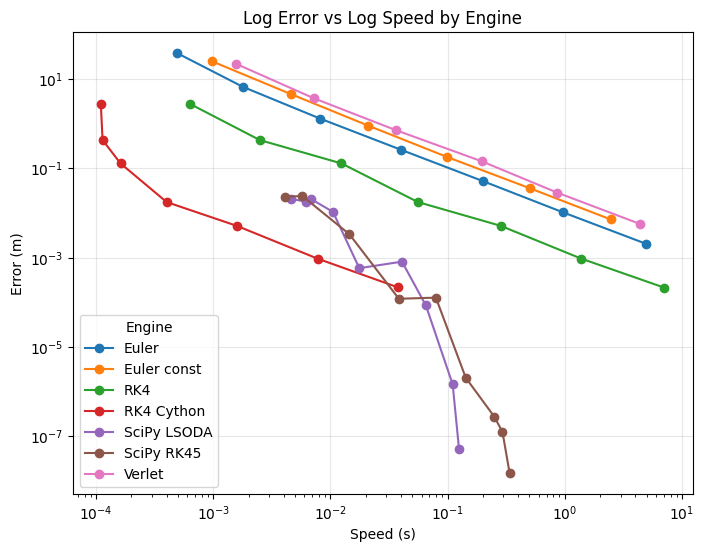

In [19]:
from matplotlib import pyplot as plt
dfplot = pd.DataFrame(summary, columns=['Engine', 'Multiplier', 'Error (m)', 'Integration Steps', 'Speed'])
fig, ax = plt.subplots(figsize=(8, 6))
for engine, group in dfplot.groupby('Engine'):
    ax.plot(group['Speed'], group['Error (m)'], marker='o', label=engine)
ax.set_xlabel('Speed (s)')
ax.set_ylabel('Error (m)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Log Error vs Log Speed by Engine')
ax.legend(title='Engine')
ax.grid(True, which='major', alpha=0.3)
plt.show()

## Data

In [22]:
display(dfplot.style.format({'Multiplier': '{:.10f}', 'Error (m)': '{:.12f}'}))

,Engine,Multiplier,Error (m),Integration Steps,Speed
0,SciPy RK45,0.0000000001,0.000000015108,8702,0.338535
1,SciPy RK45,0.0000000010,0.000000125516,7520,0.294350
2,SciPy RK45,0.0000000100,0.000000276307,6722,0.250706
3,SciPy RK45,0.0000001000,0.000002057640,5156,0.142960
4,SciPy RK45,0.0000010000,0.000127843121,3080,0.079477
5,SciPy RK45,0.0000100000,0.000120657467,1448,0.038377
6,SciPy RK45,0.0001000000,0.003347521269,512,0.014523
7,SciPy RK45,0.0010000000,0.024012462772,176,0.005760
8,SciPy RK45,0.0100000000,0.023207585512,110,0.004132
9,SciPy LSODA,0.0000000001,0.000000053528,3490,0.125152
